In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='time'>

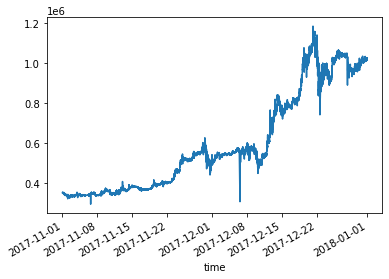

In [2]:
# 데이터 경로
DATA_PATH = '/aiffel/aiffel/fnguide/data/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

# Data Labeling

Price Change Direction

In [33]:
#window 지정
window = 10

momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) +1)

s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

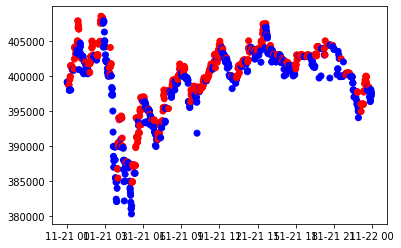

In [34]:
sub_data = modify_data.loc['2017-11-21', 'close']

c_sig = s_momentum_signal.loc['2017-11-21']

c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

Moving Average

In [35]:
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean())+1)

s_momensum_signal = pd.Series(momentum_signal, index=modify_data.index)

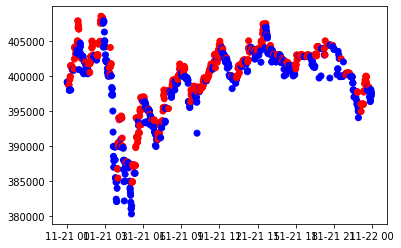

In [36]:
sub_data = modify_data.loc['2017-11-21', 'close']

c_sig = s_momentum_signal.loc['2017-11-21']

c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

Local Min-Max

In [40]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0] # ① 초기값
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
            
        if val > max_value:
            max_value = val # ② 최대값 갱신
            maxes.append(max_value) # ③ 리스트에 추가
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True # ④ 최대값 갱신 플래그 설정
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False # ⑤ 최대값 갱신 플래그 해제
            n_cnt_max += 1 # ⑥ 최대값 대기 카운트 증가
            if n_cnt_max >= wait:
                min_value = max_value # ⑦ 최소값 갱신
                n_cnt_max = 0
               
    return mins, maxes, min_idxes, max_idxes # ⑧ 결과 반환

In [48]:
# Local mins, maxes를 확인
mins, maxes, min_idxes, max_idxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인
print(mins)
print('--'*20)
print(maxes)

[399050, 399000, 398900, 398850, 398800, 398800, 398700, 397950, 401000, 400900, 400900, 400800, 403950, 403850, 403200, 403100, 403050, 403000, 407300, 406950, 406650, 400900, 402900, 400700, 400600, 400300, 402200, 402150, 402000, 401950, 401800, 401750, 401700, 401550, 401400, 401300, 401250, 401200, 401100, 400300, 400350, 401750, 401700, 400500, 404750, 404700, 404550, 403000, 402950, 402850, 402750, 402800, 402700, 402600, 402250, 404750, 408350, 408000, 408250, 408000, 407500, 404100, 407850, 407800, 407700, 404950, 404200, 404150, 403000, 402250, 402200, 402200, 402000, 402000, 401950, 401050, 400500, 400450, 400300, 400000, 399950, 400250, 400350, 400300, 400000, 401750, 401700, 400000, 397300, 397250, 395000, 392000, 389950, 388550, 387000, 388050, 385500, 385400, 384850, 382450, 382150, 382100, 385450, 390000, 389900, 389950, 389900, 391000, 390000, 389950, 389800, 389700, 388000, 386650, 384950, 382200, 387600, 387600, 386900, 387600, 387500, 387250, 385000, 384050, 383850,

(376546.5, 412585.0)

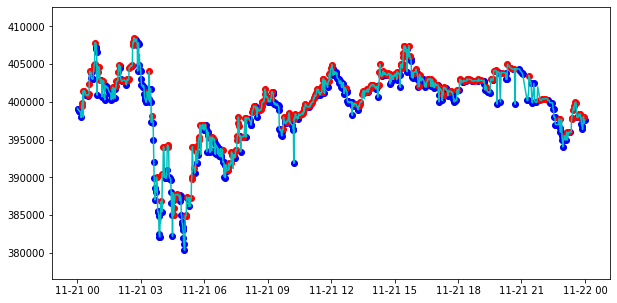

In [53]:
# subplots 및 plot 생성
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')

# min_time, local_min을 활용한 scatter plot 생성
ax.scatter(min_idxes, mins, c='b')

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(max_idxes, maxes, c='r')

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

Trend Scanning

In [54]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [55]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [59]:
# 이 코드 블럭은 실행에 20-30분정도가 소요될 수 있습니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [13:07<00:00, 42.38it/s]


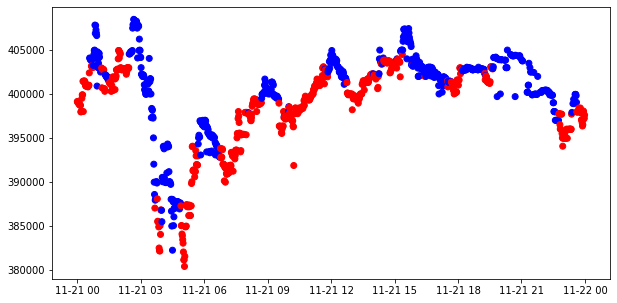

In [60]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

# Feature Engineering

In [ ]:
# !pip install ta==0.9.0
# !pip install shap

In [61]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [62]:
# 데이터 경로 설정
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

Techinal Index

In [63]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [66]:
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,52.934202,-0.0,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,44.041843,-62.5,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,41.083991,-87.5,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495


In [64]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [67]:
# Q. 코드를 작성해주세요

df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1]# iloc[:, -1] 사용

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [69]:
# Q. 코드를 작성해주세요

# RandomForest 모델 적용
rfc = RandomForestClassifier()

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier()

Feature Selection Methods

In [70]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.042640,0.001953
volume_fi,0.043515,0.002326
volume_mfi,0.050536,0.003011
volume_sma_em,0.032468,0.001786
volume_vpt,0.023512,0.001360
volatility_atr,0.065774,0.002958
volatility_ui,0.048044,0.002220
trend_macd_diff,0.088847,0.004228
trend_adx,0.051473,0.002044
trend_trix,0.065165,0.002720


In [71]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [72]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

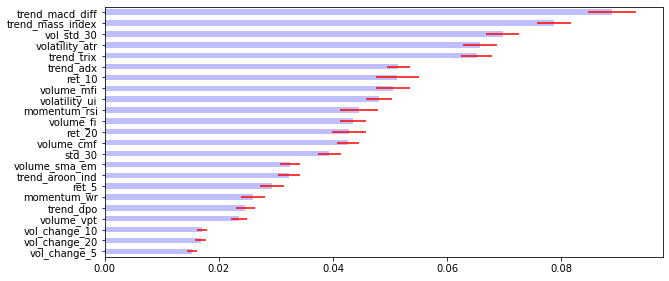

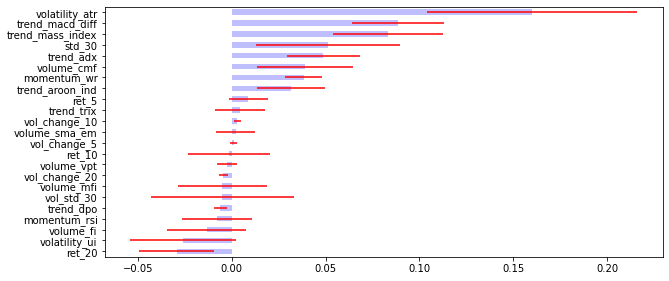

In [74]:
# Q. 코드를 작성해주세요

# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

In [76]:
# Q. 코드를 작성해주세요

# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(svc_rbf, cv=cv) # RFECV
rfe_fitted = rfe_cv.fit(X_sc, y) # fit

In [82]:
# 선택된 피쳐 확인하기

rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


In [87]:
# SFS, Sequential Feature Selection

n = 2
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [88]:
# 선택된 피쳐 확인하기

sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns={'Optimal_Features'})
sfs_df

,Optimal_Features
volume_cmf,False
volume_fi,False
volume_mfi,True
volume_sma_em,False
volume_vpt,False
volatility_atr,False
volatility_ui,False
trend_macd_diff,True
trend_adx,False
trend_trix,False


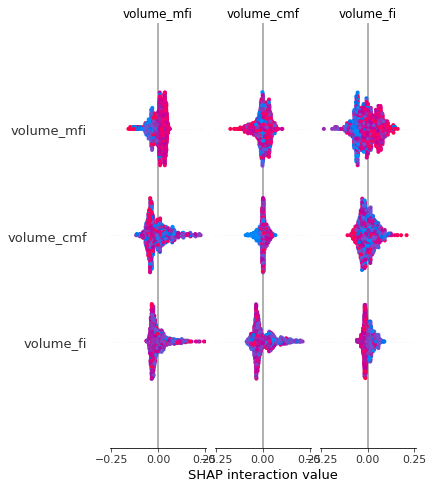

In [89]:
# Q. 코드를 작성해주세요

# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value, X_sc)

# Model Training

In [90]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [96]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data = pd.read_pickle(data_file_name)
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

Purged K-fold for Cross-Validation

In [99]:
# Q. 코드를 작성해주세요

n_cv = 4 # 앞에서 지정한 값은 4입니다. 얼마를 넣을지 생각해보고 왜 이 값을 넣었는지에 대해서 설명해봅시다.
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold 
cv = PKFold(n_cv, t1, 0)

Model 적용

In [110]:
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [3,5],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5],
             'bootstrap_features': [False, True]
            }

In [111]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [112]:
# Q. 코드를 작성해주세요

# Bagging 적용
bag_rfc = BaggingClassifier(rfc)

In [113]:
# Q. 코드를 작성해주세요

# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, n_jobs=-1, cv=cv, verbose=1)

In [114]:
# fit
gs_rfc.fit(train_x, train_y)

# best estimator 
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=3,
                                                        min_samples_leaf=5),
                  max_features=0.7)

In [115]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [133]:
# Q. 코드를 작성해주세요 
#accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve


# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y, average='macro')
recall    = recall_score(test_y, pred_y, average='macro')

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[39 17 23]
 [18 16 23]
 [ 0 12 43]]
정확도:0.5130890052356021, 정밀도:0.5076373830956918, 재현율:0.5187302740933654


In [139]:
# Q. 코드를 작성해주세요

# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

ValueError: multiclass format is not supported